<a href="https://colab.research.google.com/github/mkuczynski11/iui-project/blob/master/IUI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notatnik do projektu z IUI - Klasyfikacja dokumentów prawnych z wizualizacją za pomocą algorytmu SOM

### Importowanie bibliotek i danych

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import re, string
import shutil

# text-preprocessing
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
shutil.copyfile('./stop_words.txt', '/root/nltk_data/corpora/stopwords/polish')
# from nltk.tokenize import word_tokenize
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
!pip install morfeusz2
import morfeusz2

# model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# word embedding
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
df = pd.read_csv('./dbdata.csv', encoding='Windows-1252')

### Eksploracja danych

#### Dystybucja klas

[Text(0, 0, 'prawo cywilne'),
 Text(1, 0, 'prawo administracyjne'),
 Text(2, 0, 'prawo farmaceutyczne'),
 Text(3, 0, 'prawo pracy'),
 Text(4, 0, 'prawo medyczne'),
 Text(5, 0, 'prawo karne'),
 Text(6, 0, 'inne'),
 Text(7, 0, 'prawo podatkowe')]

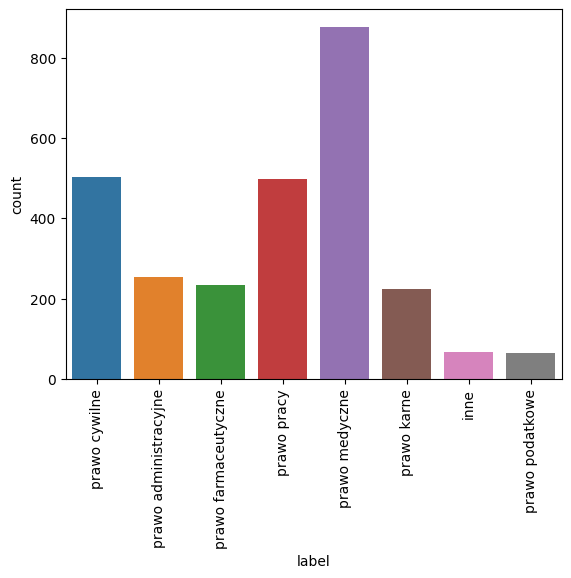

In [29]:
g = sns.countplot(x = 'label', data = df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

#### Wartości brakujące

In [32]:
print(df.isna().sum())
print(f'Samples before cleanup: {len(df)}')
df = df[df['sample'].notnull()]
print(f'Samples after removing null sample values: {len(df)}')

id        0
sample    0
label     0
dtype: int64
Samples before cleanup: 2719
Samples after removing null sample values: 2719


### Pre-processing dokumentów

#### Usunięcie znaków specjalnych itp.

In [34]:
# zamiana liter na małe, usunięcie dodatkowych spacji, usunięcie interpunkcji
def preprocess(text):
  text = text.lower()
  text = text.strip()
  text = re.compile('<.*?>').sub('', text)
  text = re.compile('[%s]' % re.escape(string.punctuation)).sub('', text)
  text = re.sub('\s+', ' ', text)
  text = re.sub(r'\[[0-9]*\]',' ',text)
  text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
  text = re.sub(r'\d',' ',text)
  text = re.sub(r'\s+',' ',text)
  return text

### Usunięcie stop-words

In [36]:
# usunięcie słów ze słownika stop-words
def stopword_removal(string):
  a= [i for i in string.split() if i not in stopwords.words('polish')]
  return ' '.join(a)

### Lemmatization

In [112]:
morf = morfeusz2.Morfeusz()
def lemmatizer(string):
  text = ""
  for word in string.split():
    analysis = morf.analyse(word)
    text = text + analysis[0][2][1].split(':')[0] + " "
  return text[:-2]

#### Rezultat pre-processingu

In [76]:
def finalpreprocess(string):
  return lemmatizer(stopword_removal(preprocess(string)))

In [77]:
df['clean_sample'] = df['sample'].apply(lambda x: finalpreprocess(x))
df.head()

,id,sample,label,clean_sample
0,0,czy wspólnota mieszkaniowa mo¿e podj¹æ uchwa³ê...,prawo cywilne,wspólnota mieszkaniowy moe podj¹æ uchwa³ê doty...
1,1,czy wspólnota mieszkaniowa mo¿e odzyskaæ pomie...,prawo cywilne,wspólnota mieszkaniowy moe odzyskaæ pomieścić ...
2,2,czy uprawnienie mieszkañców wspólnoty mieszkan...,prawo administracyjne,uprawnić mieszkañców wspólnota mieszkaniowy zg...
3,3,czy budowa windy dla osób niepe³nosprawnych mo...,prawo administracyjne,budowa winda osoba niepe³nosprawnych moe zosta...
4,4,jakie czynnoœci powinna podj¹æ wspólnota miesz...,prawo cywilne,czynnoœci podj¹æ wspólnota mieszkaniowy za³oen...


### Wektoryzacja danych za pomocą Word2Vec

In [127]:
class MeanEmbeddingVectorizer(object):
  def __init__(self, word2vec):
    self.word2vec = word2vec
    self.dim = 100

  def fit(self, X, y):
    return self

  def transform(self, X):
    return np.array([np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv] or [np.zeros(self.dim)], axis=0) for words in X])


In [116]:
w2v = KeyedVectors.load("./drive/MyDrive/word2vec_polish/fasttext_100_3_polish.bin")

In [129]:
modelw = MeanEmbeddingVectorizer(w2v)

### Trenowanie modelu klasyfikacji dokumentów

#### Splity danych

In [106]:
X_train, X_test, y_train, y_test = train_test_split(df["clean_sample"],df["label"],test_size=0.2,shuffle=True)

#### Model z wykorzystaniem danych zwektorayzowanych na podstawie bag-of-words

In [107]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [111]:
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)

y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

                       precision    recall  f1-score   support

                 inne       0.50      0.12      0.20         8
prawo administracyjne       0.55      0.34      0.42        50
        prawo cywilne       0.65      0.80      0.72       101
 prawo farmaceutyczne       0.74      0.77      0.76        48
          prawo karne       0.67      0.30      0.41        47
       prawo medyczne       0.67      0.80      0.73       171
      prawo podatkowe       1.00      0.50      0.67        14
          prawo pracy       0.82      0.81      0.81       105

             accuracy                           0.70       544
            macro avg       0.70      0.56      0.59       544
         weighted avg       0.70      0.70      0.68       544

Confusion Matrix: [[  1   2   2   0   1   2   0   0]
 [  0  17  19   1   1  10   0   2]
 [  0   2  81   1   1  14   0   2]
 [  0   0   0  37   1   8   0   2]
 [  0   2  14   0  14  16   0   1]
 [  1   5   5   8   3 137   0  12]
 [  0   1   1

### Model z wykorzystaniem danych zwektoryzowanych na podstawie Word2Vec

In [132]:
X_train_tok = [i.split() for i in X_train]
X_test_tok = [i.split() for i in X_test]

X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

In [133]:
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_w2v, y_train)

y_predict = lr_tfidf.predict(X_test_vectors_w2v)
y_prob = lr_tfidf.predict_proba(X_test_vectors_w2v)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

                       precision    recall  f1-score   support

                 inne       0.33      0.12      0.18         8
prawo administracyjne       0.49      0.38      0.43        50
        prawo cywilne       0.57      0.73      0.64       101
 prawo farmaceutyczne       0.61      0.52      0.56        48
          prawo karne       0.59      0.36      0.45        47
       prawo medyczne       0.62      0.71      0.66       171
      prawo podatkowe       0.44      0.50      0.47        14
          prawo pracy       0.68      0.60      0.64       105

             accuracy                           0.60       544
            macro avg       0.54      0.49      0.50       544
         weighted avg       0.60      0.60      0.59       544

Confusion Matrix: [[  1   0   2   1   1   2   0   1]
 [  0  19  17   0   1   9   1   3]
 [  1   8  74   2   5   8   2   1]
 [  0   3   3  25   0  10   4   3]
 [  0   1  11   2  17  13   0   3]
 [  0   6  13   7   4 121   2  18]
 [  0   2   1